# 01_explore_colab.ipynb
Self-contained exploratory data analysis for the **MIT-BIH Arrhythmia** dataset in **Google Colab**.

**What this notebook does:**
- Installs required packages
- Downloads the dataset into the Colab filesystem
- Implements minimal ECG helpers inline (AAMI mapping, loaders, bandpass filter)
- Loads and visualizes a record
- Detects R-peaks and segments beats
- Extracts simple morphology features
- Shows a small class distribution and saves a tiny preview dataset


## 1) Install dependencies

In [3]:
!pip install -q wfdb neurokit2 numpy scipy scikit-learn matplotlib pywavelets

## 2) Imports and inline helpers

In [12]:
import os, sys
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
import wfdb
import neurokit2 as nk
from scipy.signal import butter, filtfilt

# AAMI 5-class mapping for annotation symbols
AAMI_MAP = {
    'N':0,'L':0,'R':0,'e':0,'j':0,'.':0,
    'A':1,'a':1,'J':1,'S':1,
    'V':2,'E':2,
    'F':3,
    'P':4,'/':4,'f':4,'Q':4
}
AAMI_NAMES = {0:'N',1:'S',2:'V',3:'F',4:'Q'}

def list_records(db_root):
    p = Path(db_root)
    return sorted({f.stem for f in p.glob('*.hea')})

def load_record(record_path, lead=0):
    signals, fields = wfdb.rdsamp(str(record_path))
    ann = wfdb.rdann(str(record_path), extension='atr')
    sig = signals[:, lead].astype(np.float32)
    fs = fields['fs']
    r_locs = ann.sample.astype(int)
    symbols = np.array(ann.symbol)
    keep = np.array([s in AAMI_MAP for s in symbols])
    return sig, fs, r_locs[keep], np.array([AAMI_MAP[s] for s in symbols[keep]])


def bandpass(signal, fs, low=0.5, high=40.0, order=4):
    b, a = butter(order, [low/(fs/2), high/(fs/2)], btype='band')
    return filtfilt(b, a, signal)

class MorphologyFeatures:
    def __init__(self, width_threshold=0.2):
        self.width_threshold = width_threshold
    def fit(self, X, y=None):
        return self
    def transform(self, beats):
        beats = np.asarray(beats)
        peak = beats.max(axis=1)
        trough = beats.min(axis=1)
        energy = (beats**2).sum(axis=1)
        l1 = np.abs(np.diff(beats, axis=1)).sum(axis=1)
        thr = (self.width_threshold * (peak - trough) + trough)[:, None]
        above = beats >= thr
        left = above.argmax(axis=1)
        right = beats.shape[1] - np.flip(above, axis=1).argmax(axis=1)
        width = right - left
        return np.c_[peak, trough, energy, l1, width].astype(np.float32)
    def fit_transform(self, X, y=None):
        return self.fit(X, y).transform(X)

DATA_DIR = Path('mitdb_data')
DATA_DIR.mkdir(parents=True, exist_ok=True)

np.set_printoptions(precision=4, suppress=True)

## 3) Download MIT-BIH dataset into this Colab session

In [5]:
wfdb.dl_database('mitdb', dl_dir=str(DATA_DIR))
print('Downloaded to:', DATA_DIR)

Generating record list for: 100
Generating record list for: 101
Generating record list for: 102
Generating record list for: 103
Generating record list for: 104
Generating record list for: 105
Generating record list for: 106
Generating record list for: 107
Generating record list for: 108
Generating record list for: 109
Generating record list for: 111
Generating record list for: 112
Generating record list for: 113
Generating record list for: 114
Generating record list for: 115
Generating record list for: 116
Generating record list for: 117
Generating record list for: 118
Generating record list for: 119
Generating record list for: 121
Generating record list for: 122
Generating record list for: 123
Generating record list for: 124
Generating record list for: 200
Generating record list for: 201
Generating record list for: 202
Generating record list for: 203
Generating record list for: 205
Generating record list for: 207
Generating record list for: 208
Generating record list for: 209
Generati

## 4) List records and pick one to explore

In [13]:
records = list_records(str(DATA_DIR))
print('Found', len(records), 'records')
record_id = '100' if '100' in records else (records[0] if records else None)
print('Using record:', record_id)
assert record_id is not None, 'No records found; check download cell.'

Found 48 records
Using record: 100


## 5) Load signal and annotations

In [14]:
sig, fs, r_locs, y_aami = load_record(DATA_DIR/record_id, lead=0)
print(f'Signal length: {len(sig)} samples | fs={fs} Hz | annotated beats={len(r_locs)}')

Signal length: 650000 samples | fs=360 Hz | annotated beats=2273


## 6) Plot a raw snippet

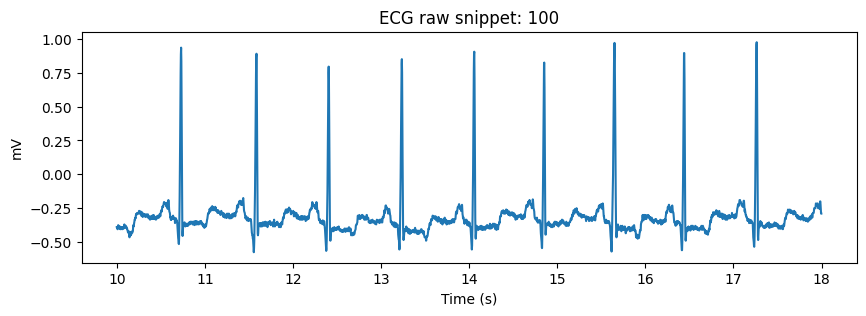

In [15]:
start_sec, dur_sec = 10, 8
a = int(start_sec * fs); b = int((start_sec+dur_sec) * fs)
t = np.arange(a, b) / fs

plt.figure(figsize=(10,3))
plt.plot(t, sig[a:b])
plt.xlabel('Time (s)'); plt.ylabel('mV'); plt.title(f'ECG raw snippet: {record_id}')
plt.show()

## 7) Bandpass filter (0.5–40 Hz) and compare

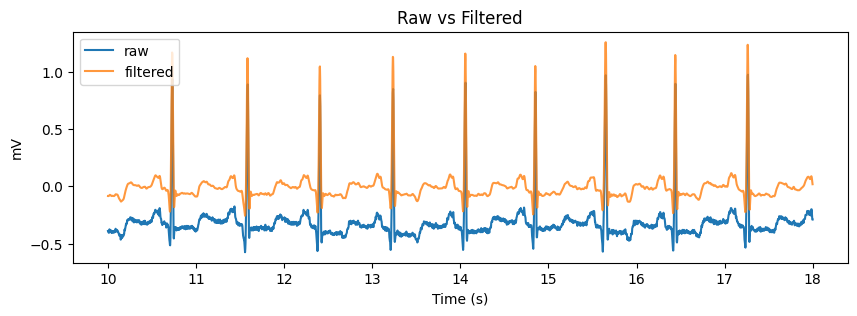

In [16]:
sig_f = bandpass(sig, fs, low=0.5, high=40.0, order=4)

plt.figure(figsize=(10,3))
plt.plot(t, sig[a:b], label='raw')
plt.plot(t, sig_f[a:b], label='filtered', alpha=0.8)
plt.legend(); plt.xlabel('Time (s)'); plt.ylabel('mV'); plt.title('Raw vs Filtered')
plt.show()

## 8) R-peak detection (NeuroKit2) and overlay

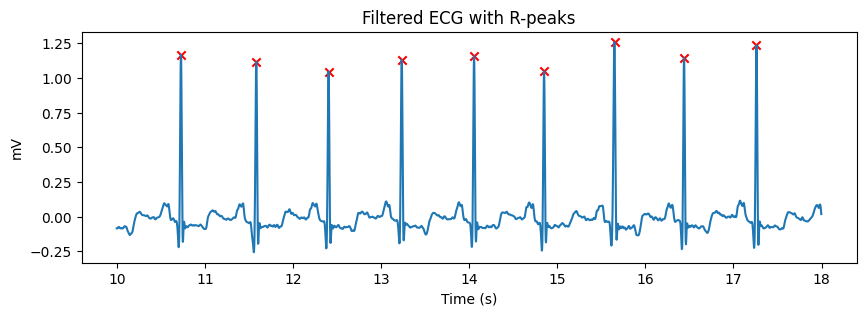

Detected peaks (full record): 2270


In [17]:
_, info = nk.ecg_peaks(sig_f, sampling_rate=fs, method='neurokit')
r_detected = info['ECG_R_Peaks']

mask = (r_detected >= a) & (r_detected < b)
r_in_win = r_detected[mask]
t_peaks = r_in_win / fs

plt.figure(figsize=(10,3))
plt.plot(t, sig_f[a:b])
plt.scatter(t_peaks, sig_f[r_in_win], marker='x', color='red')
plt.xlabel('Time (s)'); plt.ylabel('mV'); plt.title('Filtered ECG with R-peaks')
plt.show()

print('Detected peaks (full record):', len(r_detected))

## 9) Beat segmentation around R-peaks

In [18]:
pre_ms, post_ms = 200, 400
pre = int(pre_ms*fs/1000); post = int(post_ms*fs/1000)

beats = []
keep = []
for r in r_detected:
    a0 = max(0, r - pre); b0 = min(len(sig_f), r + post)
    seg = sig_f[a0:b0]
    if len(seg) == pre + post:
        beats.append(seg); keep.append(r)

beats = np.vstack(beats) if len(beats) else np.empty((0, pre+post))
print('Beats segmented:', beats.shape)

Beats segmented: (2270, 216)


## 10) Visualize a few beats

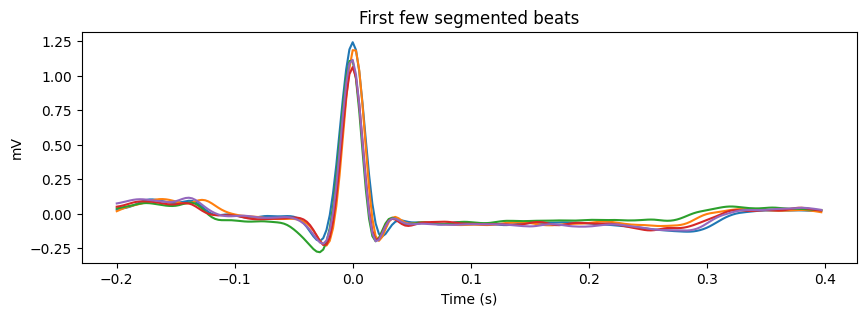

In [19]:
if len(beats):
    n_show = min(5, len(beats))
    x = np.arange(beats.shape[1]) / fs - (pre/fs)
    plt.figure(figsize=(10,3))
    for i in range(n_show):
        plt.plot(x, beats[i])
    plt.xlabel('Time (s)'); plt.ylabel('mV'); plt.title('First few segmented beats')
    plt.show()
else:
    print('No beats segmented; check earlier cells.')

## 11) Quick class distribution (local sample)

Class distribution:
  N: 2236
  S: 33
  V: 1


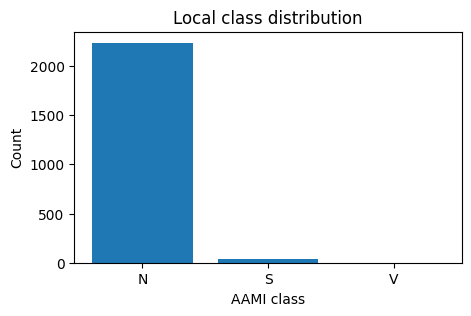

In [20]:
y = y_aami[:len(beats)] if len(beats) else np.array([], dtype=int)
unique, counts = np.unique(y, return_counts=True)
print('Class distribution:')
for u, c in zip(unique, counts):
    print(f'  {AAMI_NAMES.get(int(u), u)}: {c}')

if len(unique):
    plt.figure(figsize=(5,3))
    plt.bar([AAMI_NAMES.get(int(u), str(u)) for u in unique], counts)
    plt.xlabel('AAMI class'); plt.ylabel('Count'); plt.title('Local class distribution')
    plt.show()

## 12) Morphology feature preview

In [21]:
if len(beats):
    F = MorphologyFeatures().fit_transform(beats)
    print('Feature matrix shape:', F.shape)
    print('First row (peak, trough, energy, l1, width):\n', F[0])
else:
    print('No beats to featurize.')

Feature matrix shape: (2270, 5)
First row (peak, trough, energy, l1, width):
 [ 1.241  -0.1974  9.8727  3.733  70.    ]


## 13) Save a tiny preview dataset

In [22]:
OUT = Path('preview_beats_colab.npz')
if len(beats):
    np.savez(OUT, beats=beats, y=y, fs=fs, pre=pre, post=post)
    print('Saved preview to', OUT)
else:
    print('Skipped saving: no beats found.')

Saved preview to preview_beats_colab.npz
